In [1]:
from imblearn.over_sampling import SMOTE, ADASYN
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn import metrics
import time
from datetime import datetime, timedelta
from sklearn import svm
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn import preprocessing
from math import sqrt
import seaborn as sns; sns.set()
import ast
from keras.models import Sequential
from keras.layers import Dense


def smote(x,y):
    X_resampled, y_resampled = SMOTE().fit_sample(x, y)
    #print('check',sum(y_resampled)/len(y_resampled))
    return X_resampled,y_resampled


/home/simone/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
tickers = ['AAPL','AMZN','GOOGL','MSFT','FB','INTC','CSCO','CMCSA','NVDA','NFLX'] 
TREND_WINDOWs = [1, 4, 7, 14, 21, 28, 49]
newsPath = '/home/simone/Desktop/NLFF/intrinioDatasetUpdated/SentimentFullAggregatedHourly/'
pricePath = '/home/simone/Desktop/NLFF/indexes/indexes'

In [3]:

def NN(input_dim):
    model = Sequential()
    model.add(Dense(12, input_dim=input_dim, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def NN_regression(input_dim):
    model = Sequential()
    model.add(Dense(12, input_dim=input_dim, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [ ]:
## CLASSIFICATION with smote on train and test

tic_Acc = {}
tic_MCC = {}
for ticker in tickers:
    print('\n\n======================= ',ticker,'============================\n')
    news =  pd.read_csv(newsPath+ticker+'.csv')
    price =  pd.read_csv(pricePath+ticker+'.csv')
    price = price.rename(index=str, columns={"date": "DATE"})
    news = news.rename(index=str, columns={"initTime": "DATE"})
    news['DATE'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in news['DATE']]
    # This datased is already GMT+0
    price['DATE'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in price['DATE']]
    #ALLIGNMENT
    initDate = datetime(2017,5,22,14,0,0)
    finalDate = datetime(2018,6,20,19,0,0)
    price.drop(price[price.DATE > finalDate].index, inplace=True)
    price.drop(price[price.DATE < initDate].index, inplace=True)
    price = price.reset_index(drop=True)
    news.drop(news[news.DATE > finalDate].index, inplace=True)
    news.drop(news[news.DATE < initDate].index, inplace=True)
    news = news.reset_index(drop=True)

    #Controllo allignment
    for data in news['DATE']:
        if data not in price['DATE'].tolist():
            print(data)
    assert len(price) == len(news)

    # FEATURES EXTRACTION
    sentiment = news.drop(['Unnamed: 0', 'DATE'], axis=1)
    X = pd.concat([sentiment, sentiment.rolling(5).mean()],axis=1)
    X = pd.concat([X, sentiment.rolling(10).mean()],axis=1)
    X = pd.concat([X, sentiment.rolling(15).mean()],axis=1)
    X = pd.concat([X, sentiment.rolling(20).mean()],axis=1)

    X = np.nan_to_num(np.asarray(X, dtype=float))
    min_max_scaler = preprocessing.MinMaxScaler()
    X = np.asarray(min_max_scaler.fit_transform(X))
    
    accs = list()
    MCCs = list()
    for TREND_WINDOW in TREND_WINDOWs:
        #CONSTRUCT LABELS
        y = list()
        x = list()
        up = 0
        down = 0
        for i in range(0,len(price)-TREND_WINDOW):
            s=np.sign(price.iloc[i+TREND_WINDOW]['close']-price.iloc[i]['close'])
            if(s==-1):
                y.append(0)
                down +=1
            else:
                y.append(1)
                up +=1
            x.append(X[i])
        
        
        #EXPERIMENT
        y = np.array(y)
        x = np.array(x)
        train=0.8
        nt=math.ceil(len(x)*train)
        x_tv = x[:nt]
        y_tv = y[:nt]
        x_test = x[nt:]
        y_test = y[nt:]
#         cSpace = np.logspace(-4,4,10)
#         #MODEL SELECTION: CV
#         best_c = 0
#         best_acc = 0
#         for c in range(0,10):
#             cvacclist = list()
#             print('.', end='')
#             trainpoint=math.floor(len(x_tv)*0.50)
#             dimval=math.floor((len(x_tv)-trainpoint)*0.25)
#             endval=trainpoint+dimval
#             for i in range(0,4):
#                 x_train = x_tv[0:trainpoint]
#                 y_train = y_tv[0:trainpoint]
#                 x_val = x_tv[trainpoint:endval]
#                 y_val = y_tv[trainpoint:endval]
#                 trainpoint = trainpoint+dimval
#                 endval = endval+dimval
#                 nn = NN(kernel='linear',C=cSpace[c])
#                 x_train,y_train = smote(x_train,y_train)
#                 x_val,y_val = smote(x_val,y_val)
#                 rbf_svm.fit(x_train,y_train)
#                 acc = rbf_svm.score(x_val,y_val)
#                 cvacclist.append(acc)
                
#             cvacc=sum(cvacclist)/len(cvacclist)
#             if(cvacc > best_acc):
#                 best_acc=cvacc
#                 best_c = cSpace[c]
        
        nn = NN(x_tv.shape[1])
        x_tv,y_tv = smote(x_tv,y_tv)
        print('Train % up: '+"{0:.2f}".format(sum(y_tv)/len(y_tv)))
        x_test,y_test = smote(x_test,y_test)
        print('Test % up: '+"{0:.2f}".format(sum(y_test)/len(y_test)))
        
        
        history = nn.fit(x_tv,y_tv, validation_data=(x_test, y_test), epochs=150, batch_size=128,verbose=0)
        plt.figure(figsize=(15,7))
        plt.plot(history.history['acc'], 'b' , label='acc_train')
        plt.plot(history.history['val_acc'],'r', label='acc_test')
        plt.plot(history.history['loss'], 'b--', label='loss_train')
        plt.plot(history.history['val_loss'], 'r--', label='loss_test')
        plt.title('Trend '+str(TREND_WINDOW))
        plt.xlabel('epoch')
        plt.legend()
        plt.show()
#         y_pred = [1 if p>0.5 else 0 for p in y_pred]
#         confmatrix = confusion_matrix(y_test, y_pred)
#         tn, fp, fn, tp = confmatrix.ravel()
#         denom = (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)
#         accs.append(acc)
#         MCCs.append(0 if denom== 0 else (tp*tn -fp*fn)/sqrt(denom) )

#     plt.figure(figsize=(15,7))
#     plt.plot(range(len(MCCs)), MCCs, label='MCC_'+ticker, linestyle='dashed')
#     plt.plot(range(len(accs)), accs, label='acc_'+ticker)
#     print('MCCs: ', MCCs)
#     print('Accs: ',accs)
#     tic_Acc[ticker] = accs
#     tic_MCC[ticker] = MCCs

# plt.legend()
# plt.show()



=======================  AAPL ============================



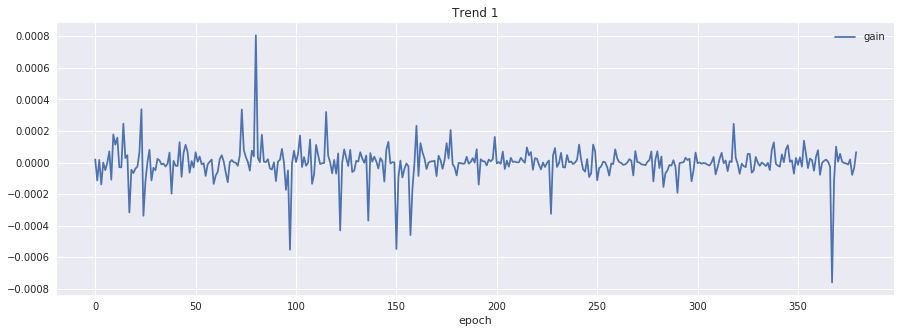

Acc: 0.52
TotGain: -0.0010432404321081468


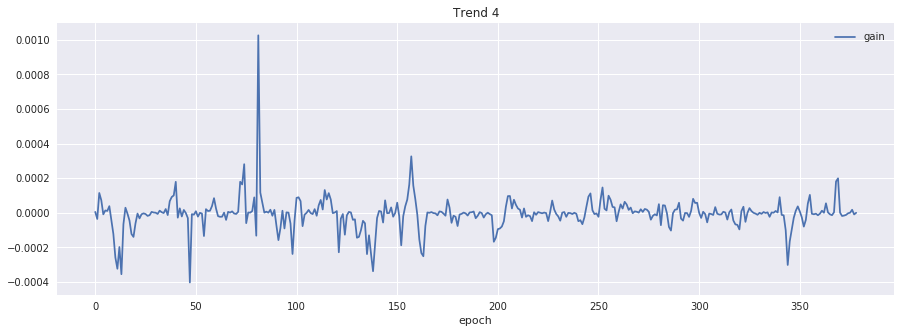

Acc: 0.46
TotGain: -0.0025134881124015693


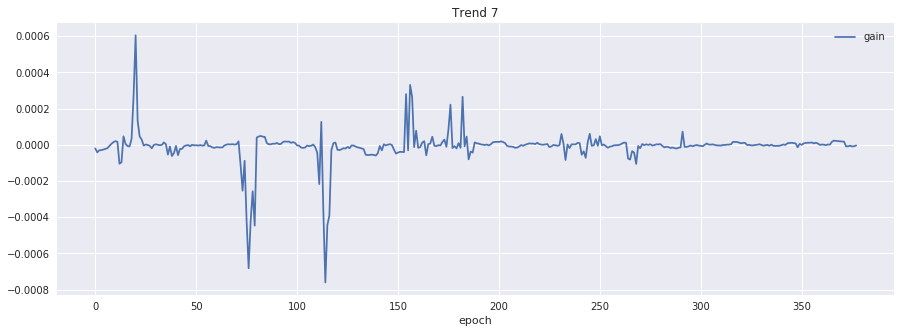

Acc: 0.42
TotGain: -0.003969459752269341


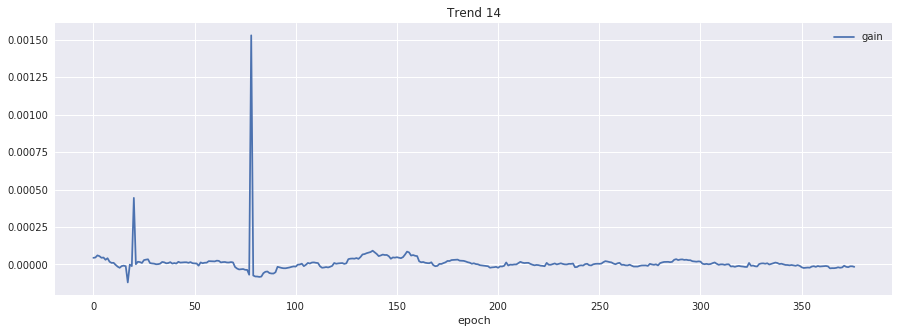

Acc: 0.59
TotGain: 0.0037925790557142023


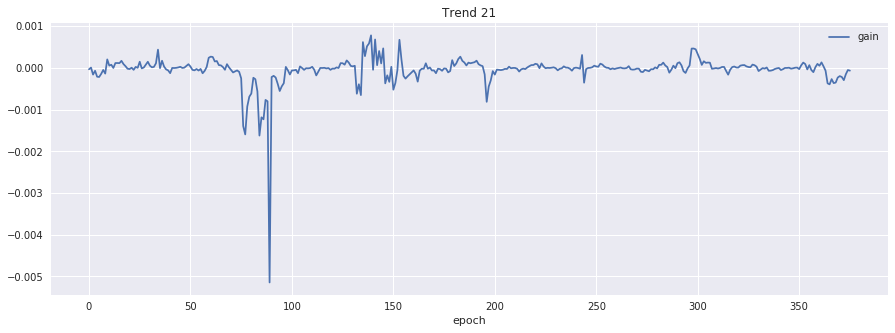

Acc: 0.44
TotGain: -0.018219943672023405


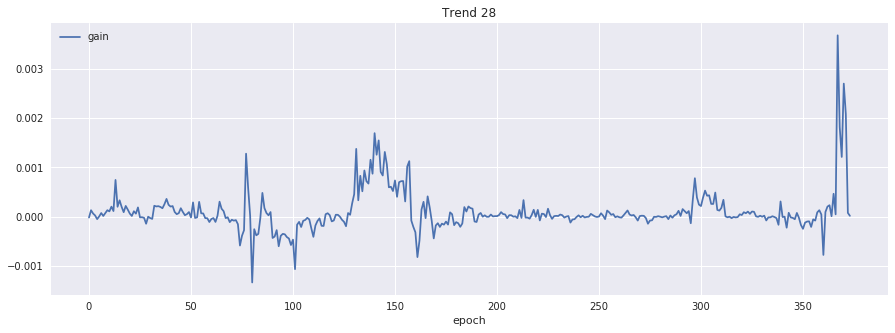

Acc: 0.61
TotGain: 0.039210382759600516


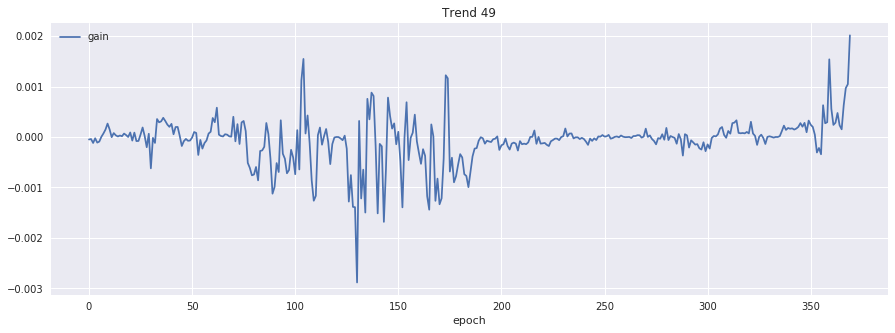

Acc: 0.47
TotGain: -0.0276763794717243


=======================  AMZN ============================



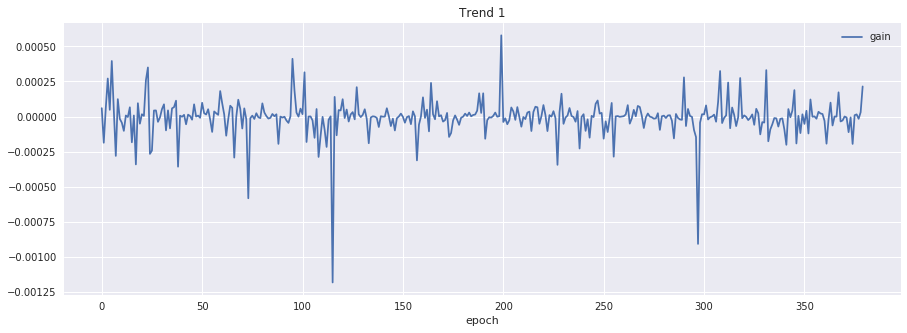

Acc: 0.50
TotGain: -0.0028890944612850584


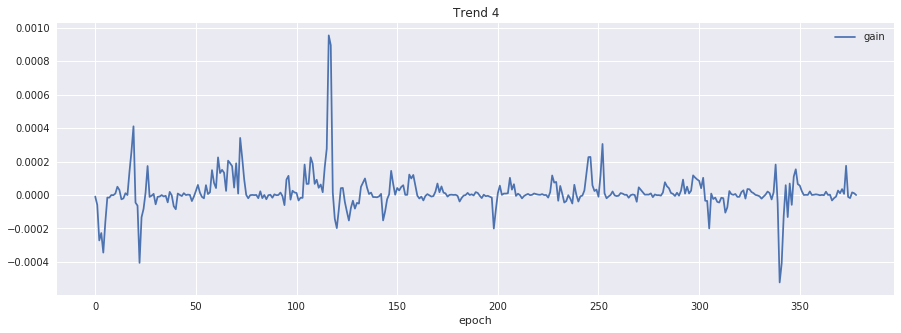

Acc: 0.59
TotGain: 0.006161705853306944


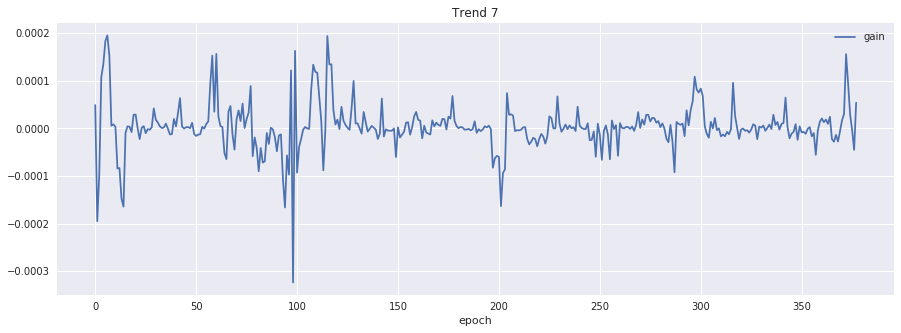

Acc: 0.54
TotGain: 0.00132568837914041


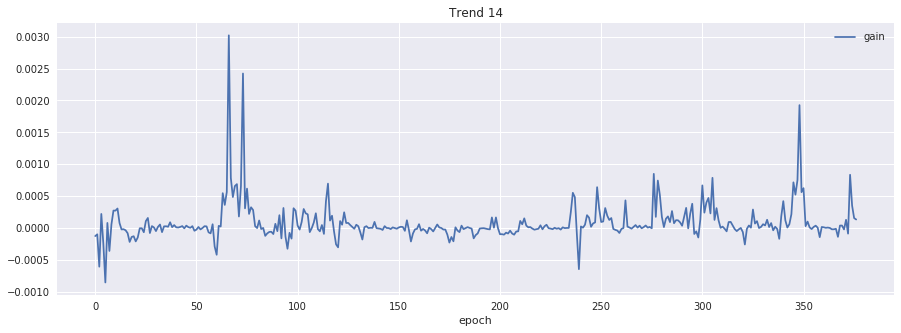

Acc: 0.58
TotGain: 0.029537097463065865


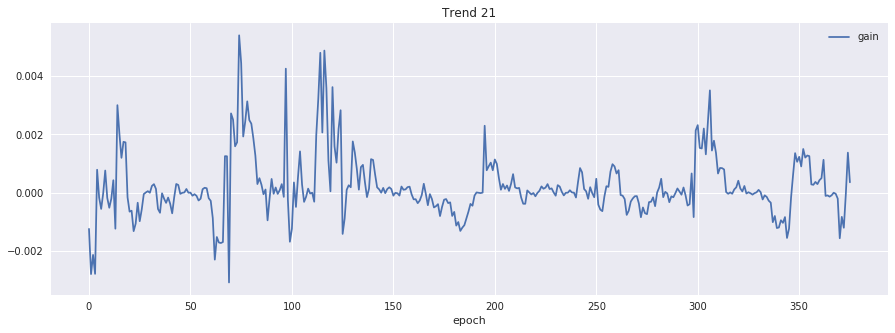

Acc: 0.52
TotGain: 0.07969111209270924


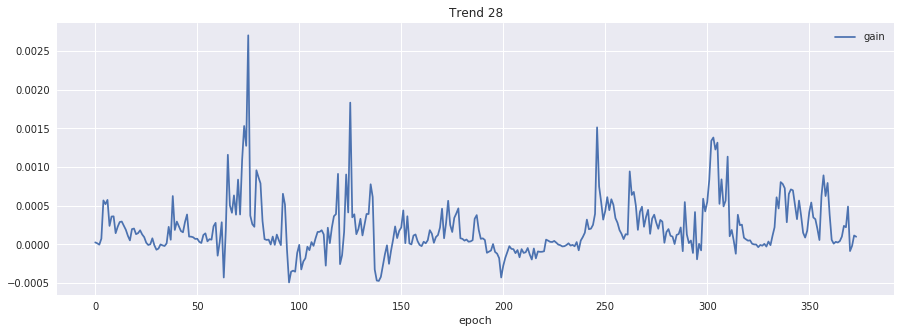

Acc: 0.76
TotGain: 0.07880839465337419


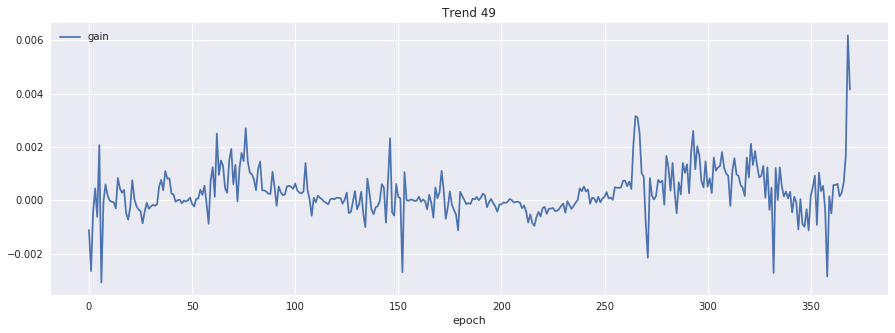

Acc: 0.63
TotGain: 0.10420841552751084


=======================  GOOGL ============================



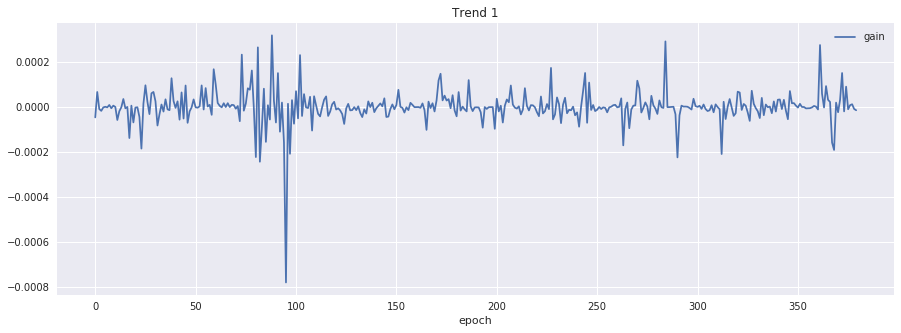

Acc: 0.47
TotGain: 0.00028150175177061643


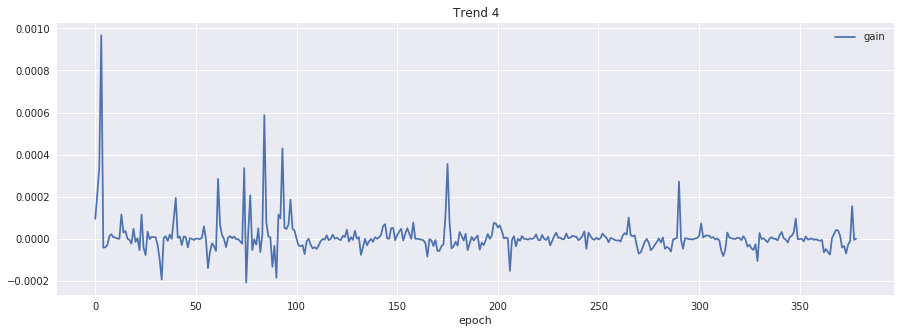

Acc: 0.51
TotGain: 0.003363126355378186


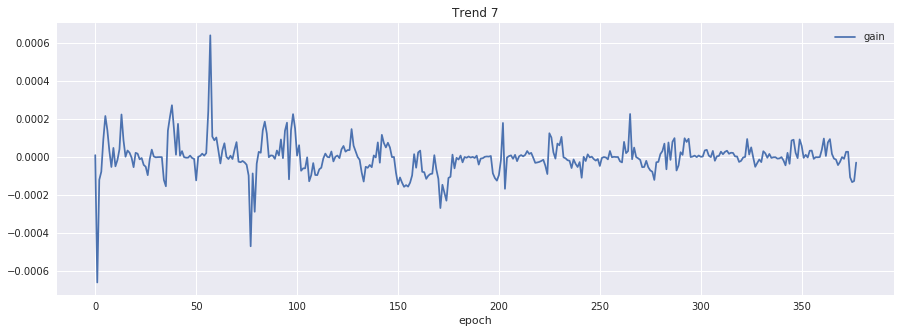

Acc: 0.49
TotGain: -0.0007772552891815508


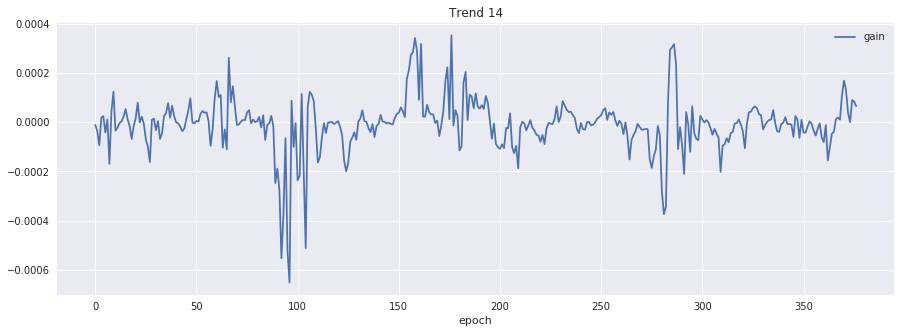

Acc: 0.46
TotGain: -0.0035512501593075196


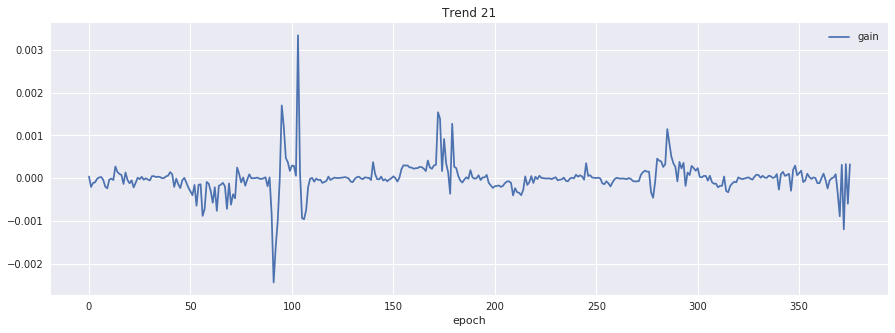

Acc: 0.48
TotGain: -0.0019895618777048423


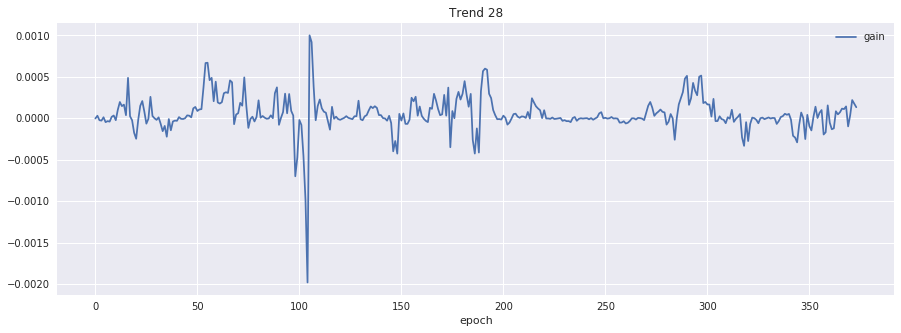

Acc: 0.61
TotGain: 0.01845546028326909


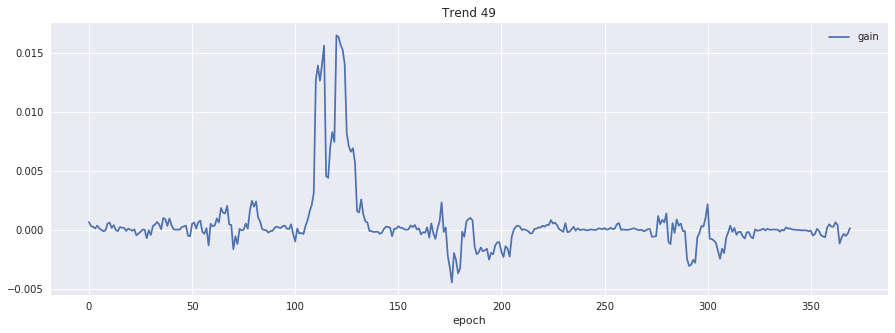

Acc: 0.54
TotGain: 0.18022784755028684


=======================  MSFT ============================



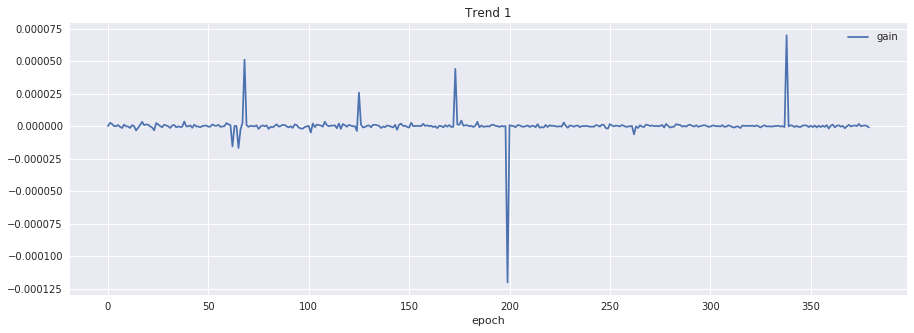

Acc: 0.55
TotGain: 6.648893800406388e-05


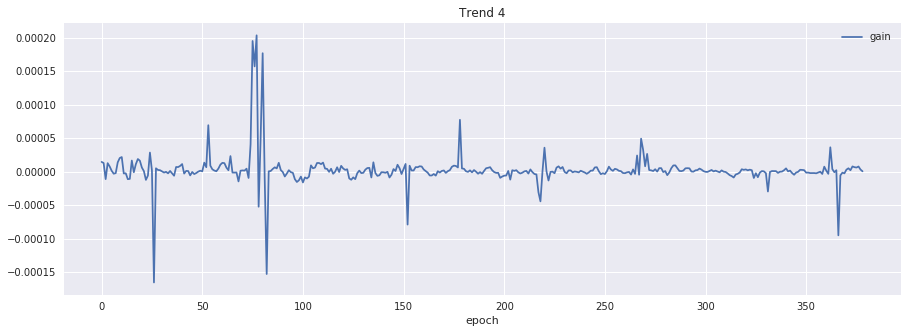

Acc: 0.57
TotGain: 0.0008990951241473221


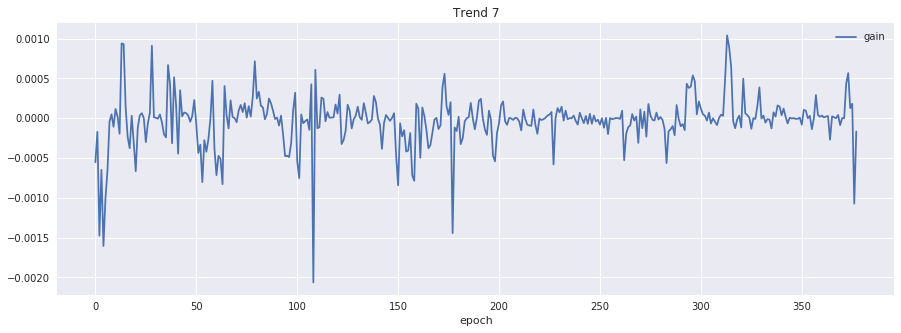

Acc: 0.49
TotGain: -0.013020431069131535


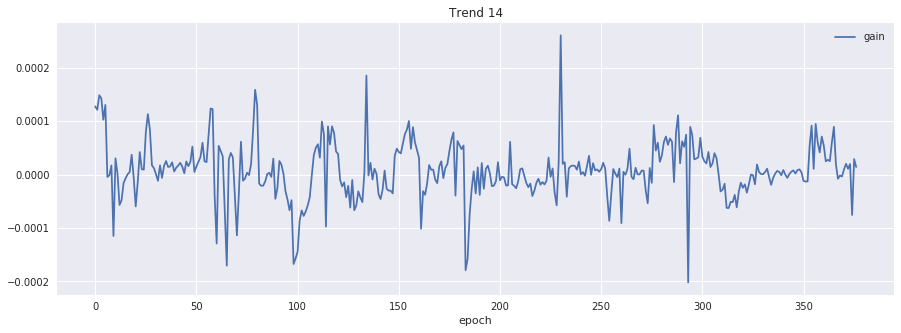

Acc: 0.59
TotGain: 0.0028792689352123164


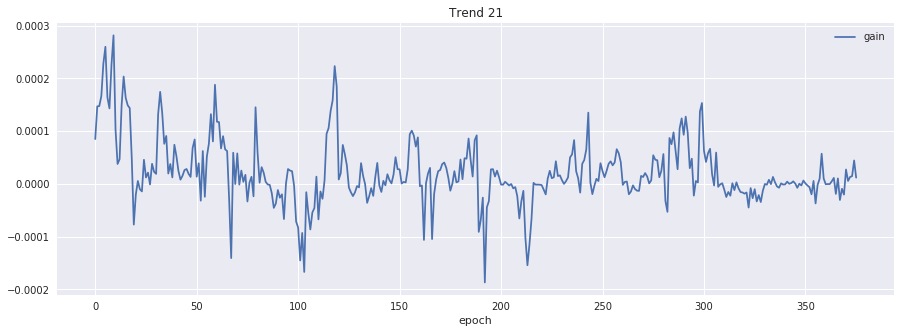

Acc: 0.63
TotGain: 0.008003598647245461


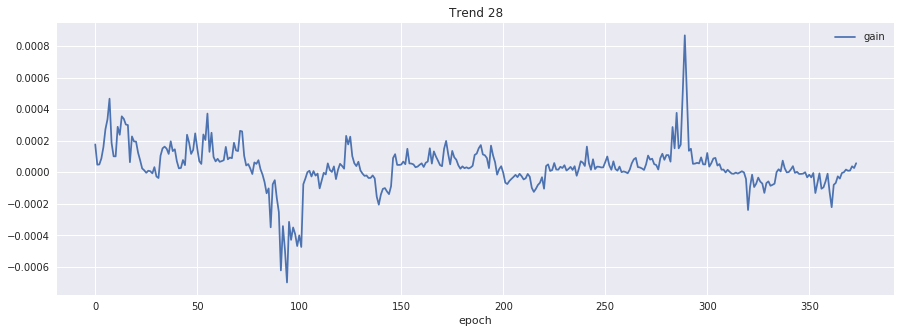

Acc: 0.68
TotGain: 0.012019653257277836


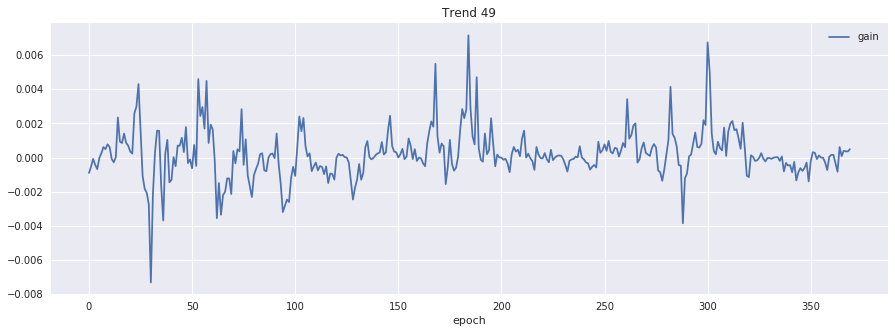

Acc: 0.55
TotGain: 0.07570802746532553


=======================  FB ============================



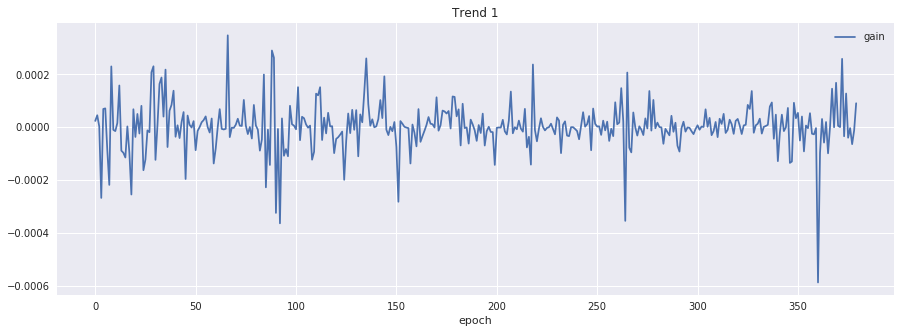

Acc: 0.52
TotGain: 0.0009244751105925266


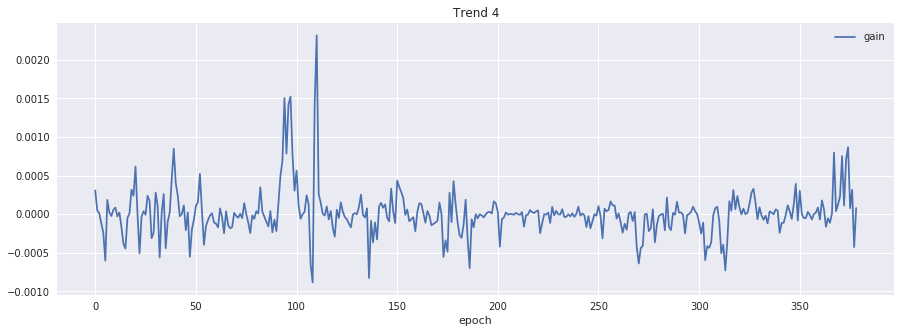

Acc: 0.51
TotGain: 0.003914918078526474


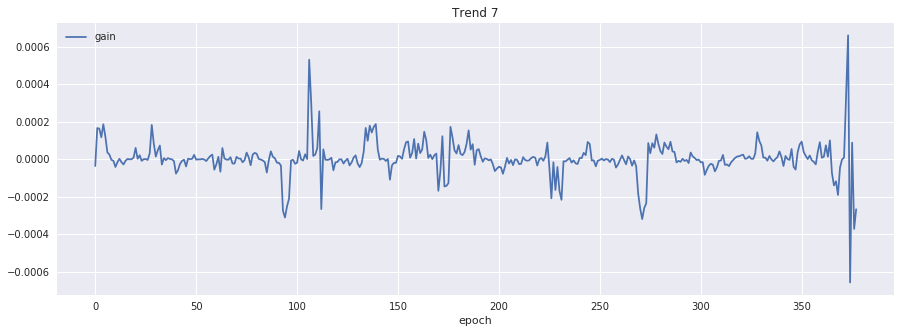

Acc: 0.49
TotGain: 0.000669415196414878


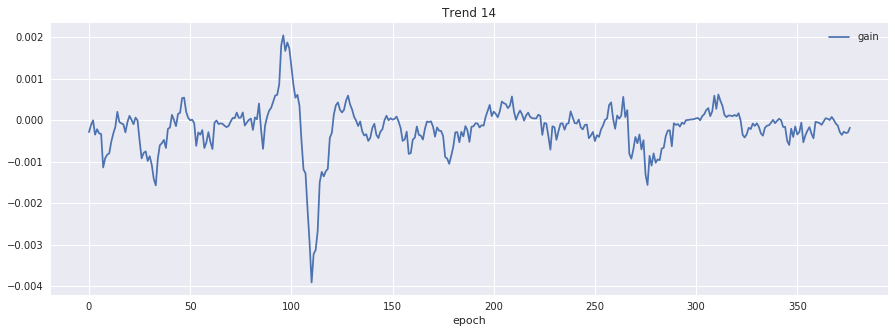

Acc: 0.34
TotGain: -0.07326962547311658


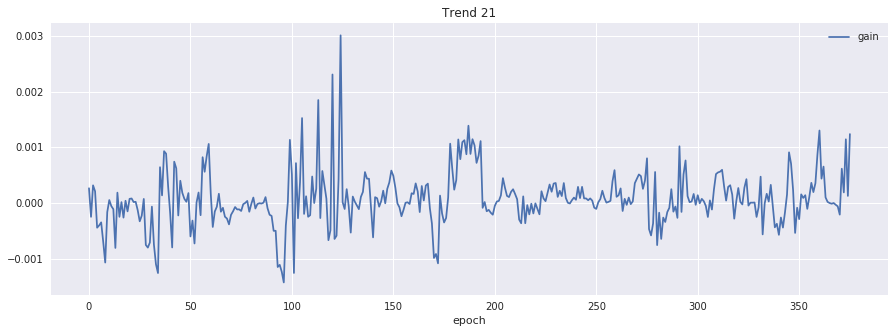

Acc: 0.57
TotGain: 0.027609238505274917


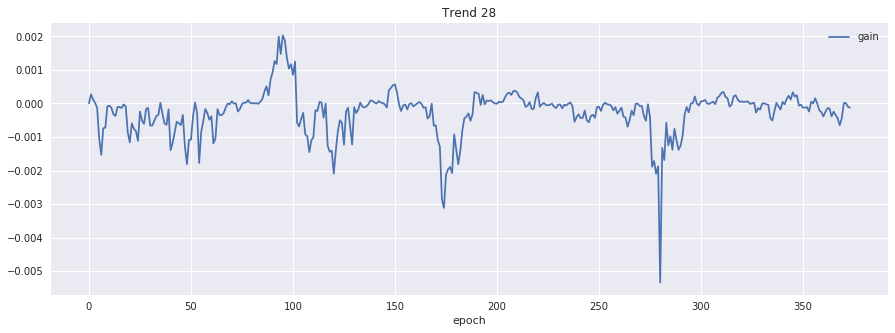

Acc: 0.31
TotGain: -0.10079128192542465


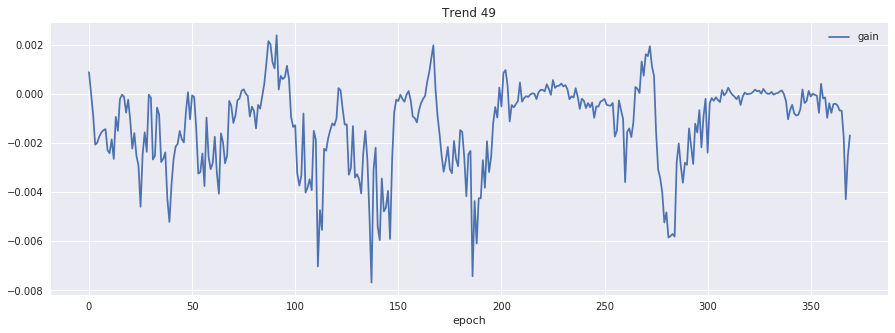

Acc: 0.22
TotGain: -0.46683862582362334


=======================  INTC ============================



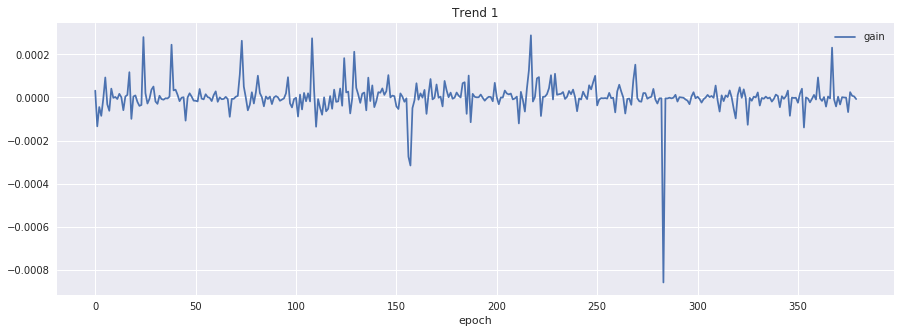

Acc: 0.50
TotGain: 0.0005778965663213254


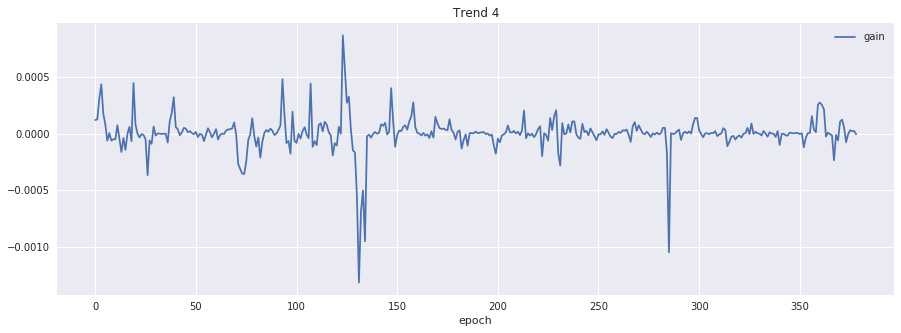

Acc: 0.53
TotGain: 0.00015931628495149665


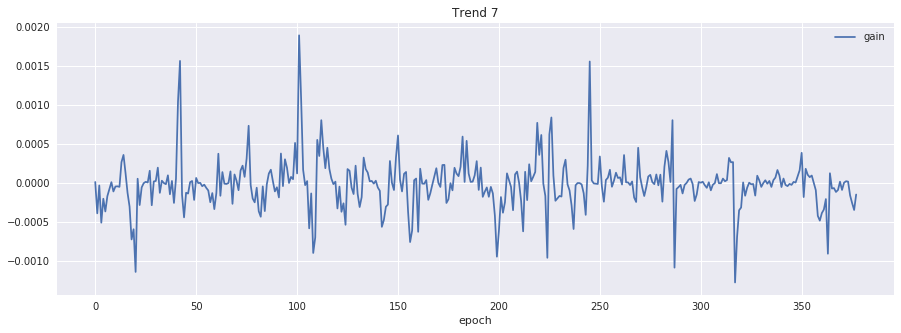

Acc: 0.47
TotGain: -0.005867863676135419


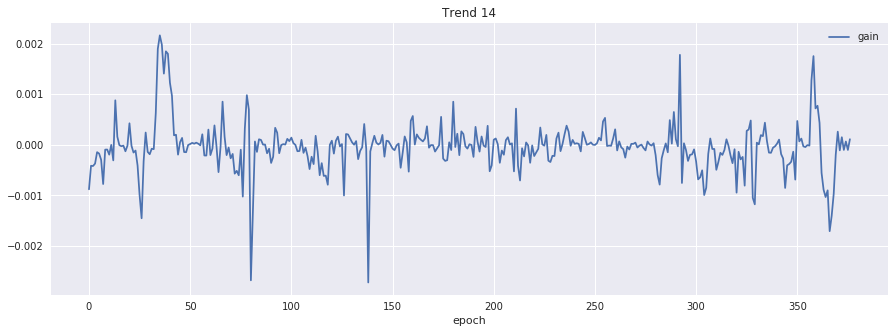

Acc: 0.43
TotGain: -0.018472568215309026


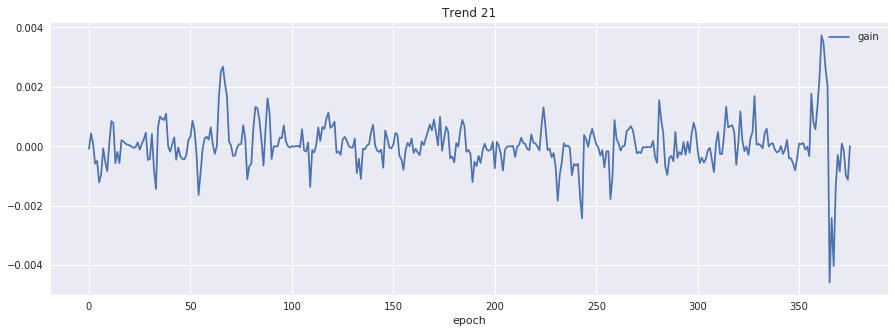

Acc: 0.51
TotGain: 0.014870807936986172


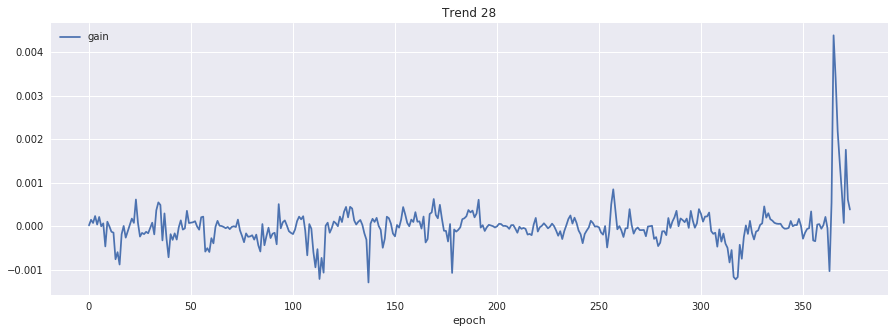

Acc: 0.48
TotGain: -0.0028956205369687358


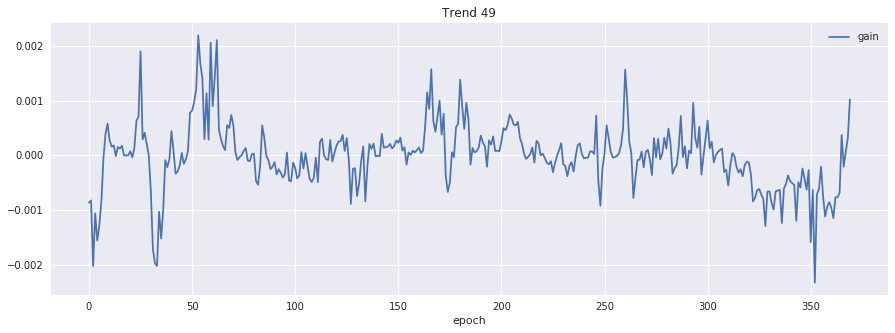

Acc: 0.51
TotGain: -0.0078399232655163


=======================  CSCO ============================



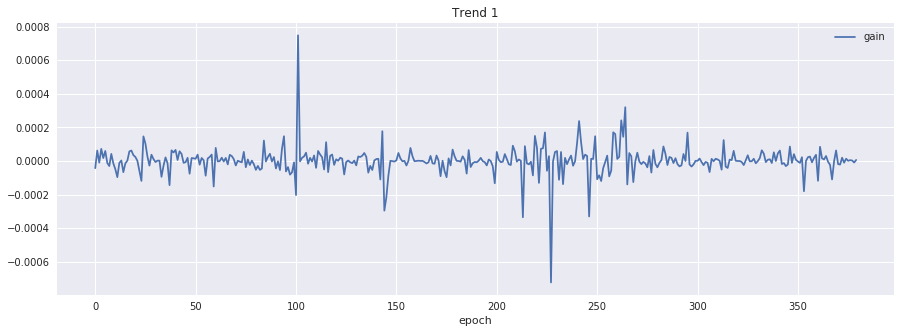

Acc: 0.52
TotGain: 0.0006024808118497278


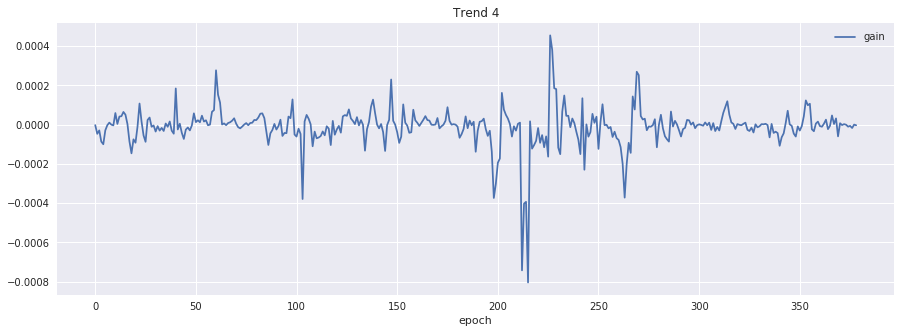

Acc: 0.47
TotGain: -0.004330707940297162


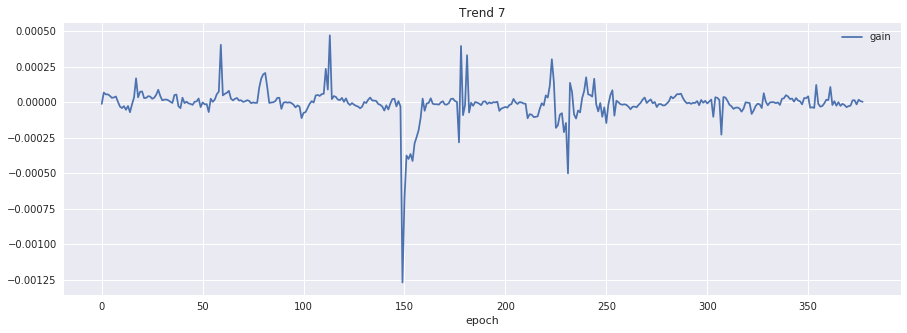

Acc: 0.46
TotGain: -0.003047643398857007


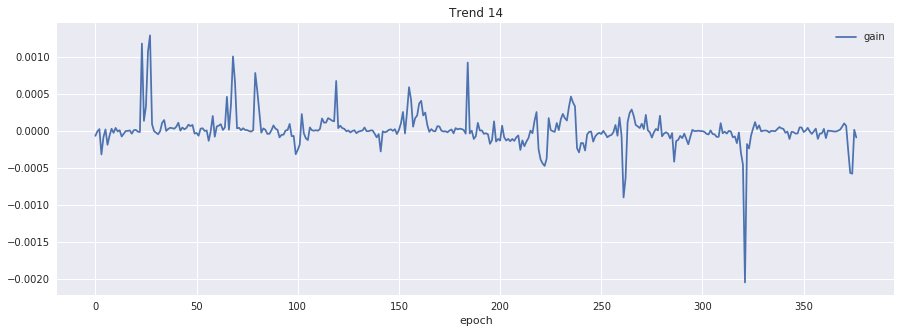

Acc: 0.50
TotGain: 0.0042201656995532535


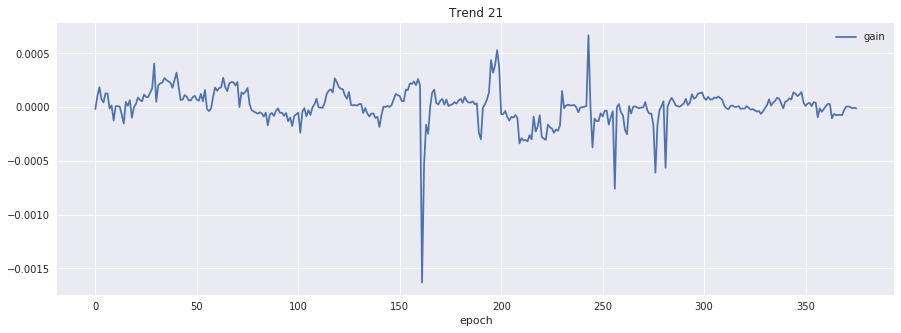

Acc: 0.59
TotGain: 0.0036632134519450337


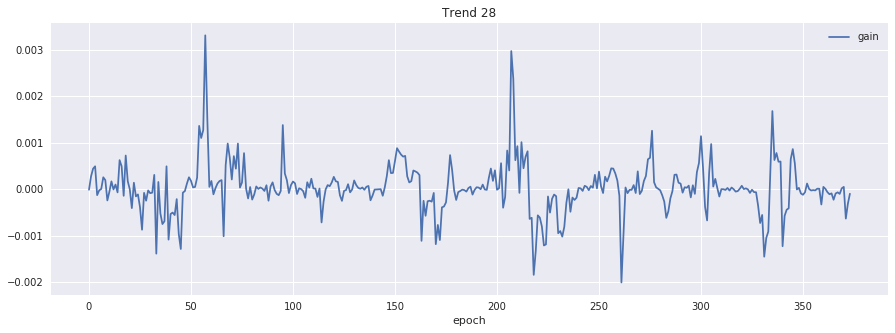

Acc: 0.52
TotGain: 0.010379647649407225


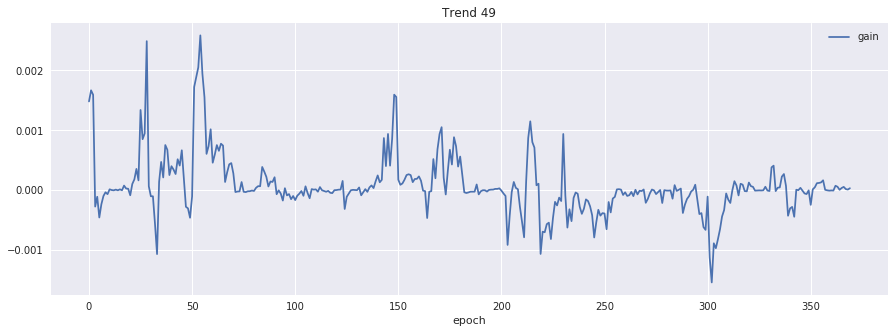

Acc: 0.49
TotGain: 0.02657446764508459


=======================  CMCSA ============================



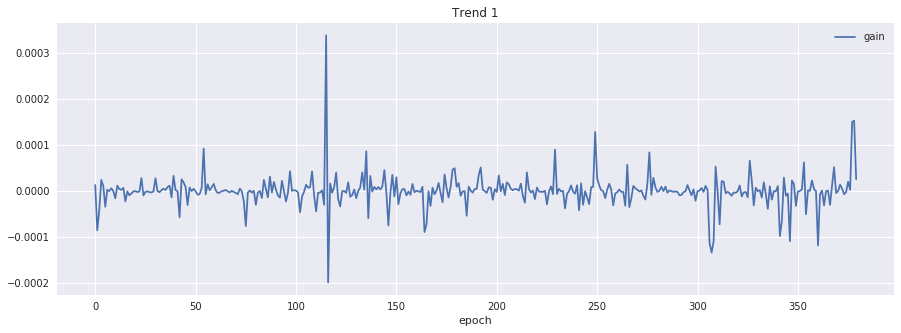

Acc: 0.50
TotGain: 0.00017518739530332047


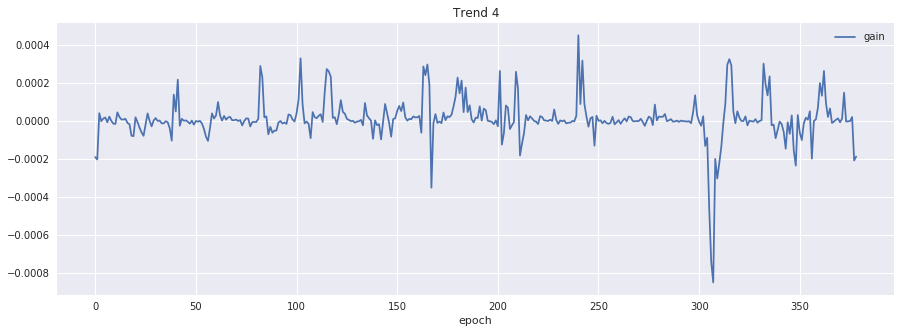

Acc: 0.57
TotGain: 0.004162712655131327


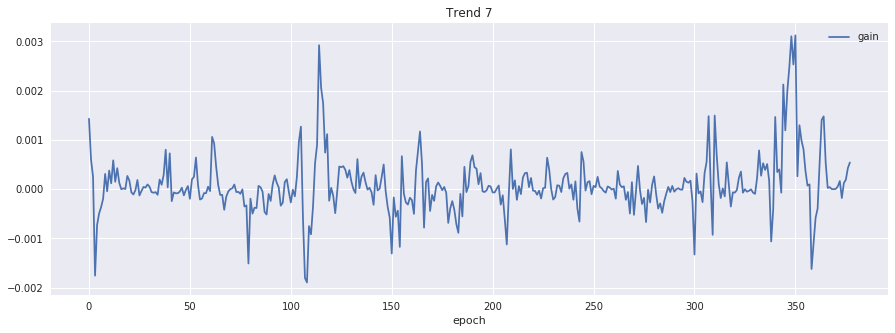

Acc: 0.53
TotGain: 0.03197132940796391


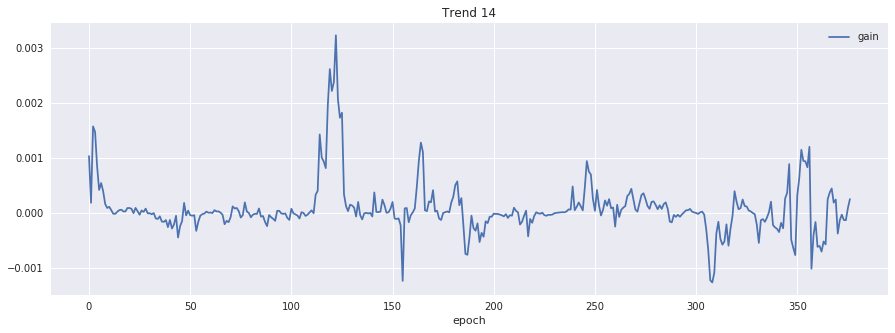

Acc: 0.54
TotGain: 0.02912224640980698


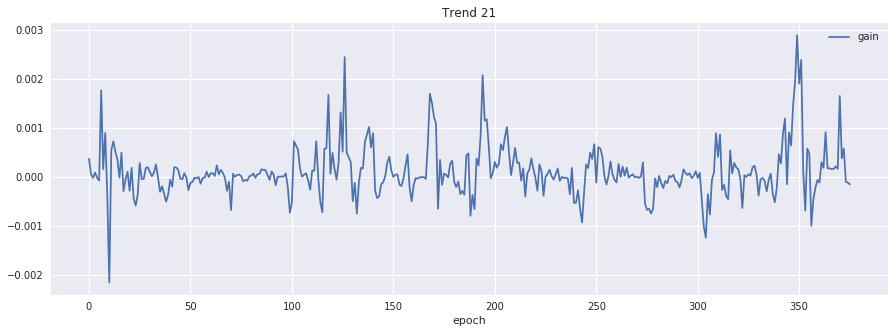

Acc: 0.56
TotGain: 0.03963619191353565


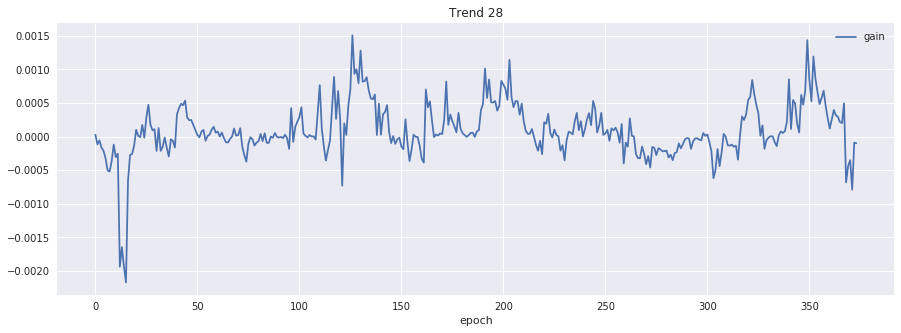

Acc: 0.59
TotGain: 0.03407151935776561


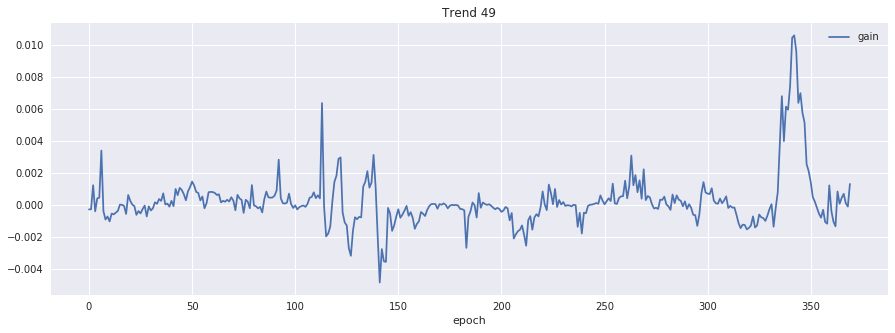

Acc: 0.51
TotGain: 0.0783698032697374


=======================  NVDA ============================



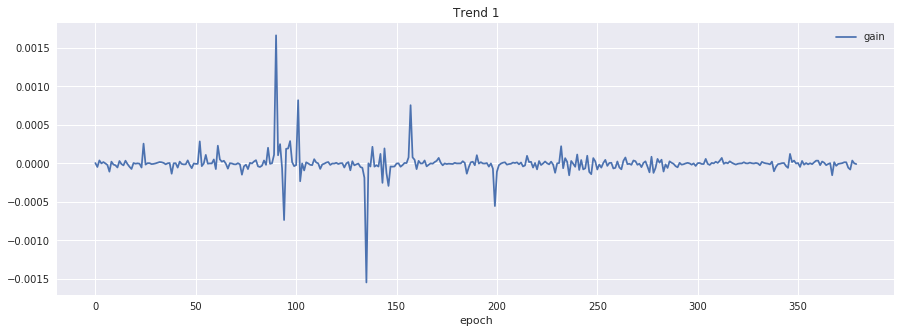

Acc: 0.49
TotGain: -0.0004074130605515269


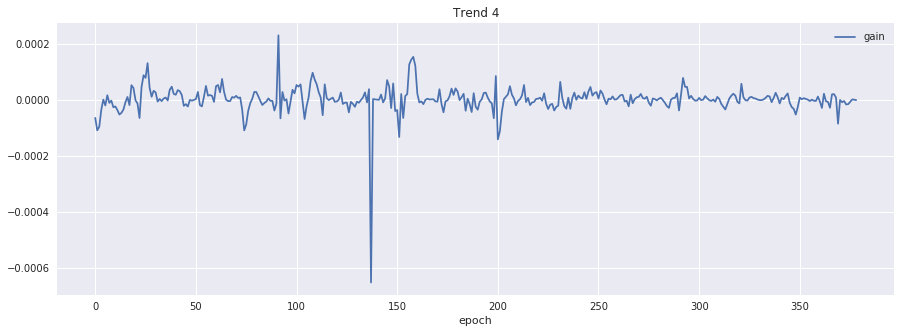

Acc: 0.55
TotGain: 0.00041556354479262153


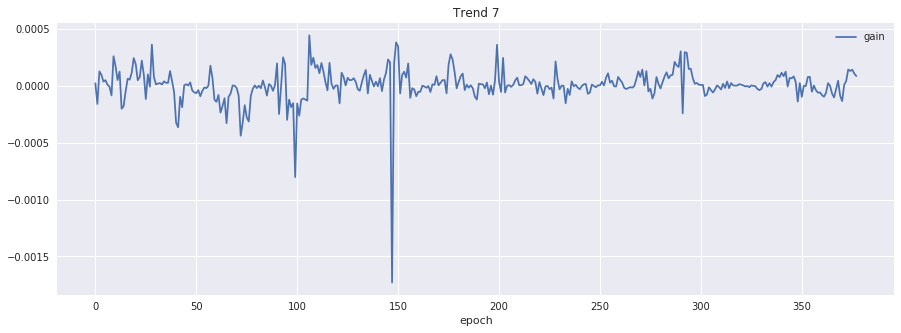

Acc: 0.55
TotGain: 0.002041156786771628


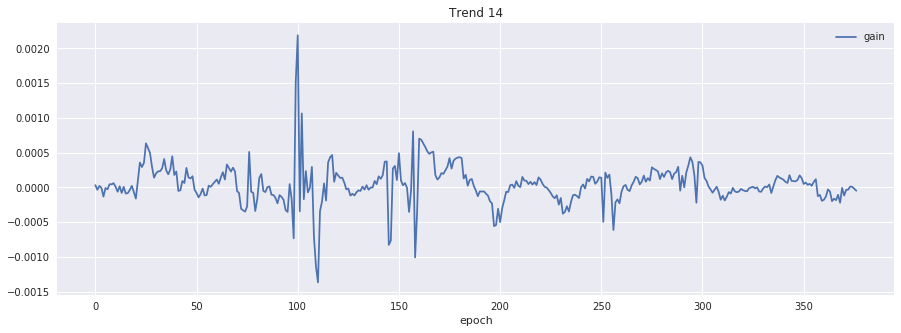

Acc: 0.57
TotGain: 0.0156464009934286


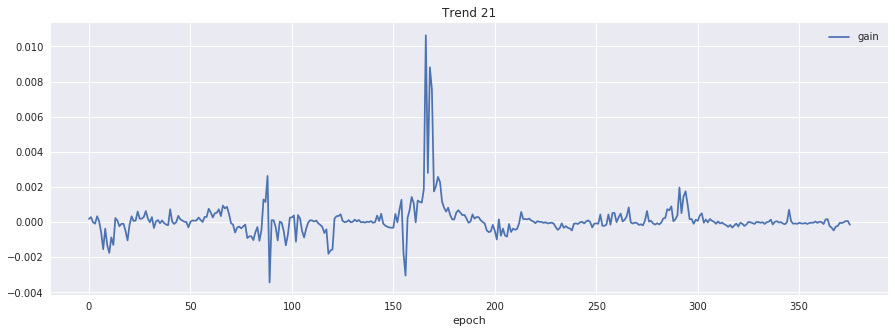

Acc: 0.49
TotGain: 0.03849153797198583


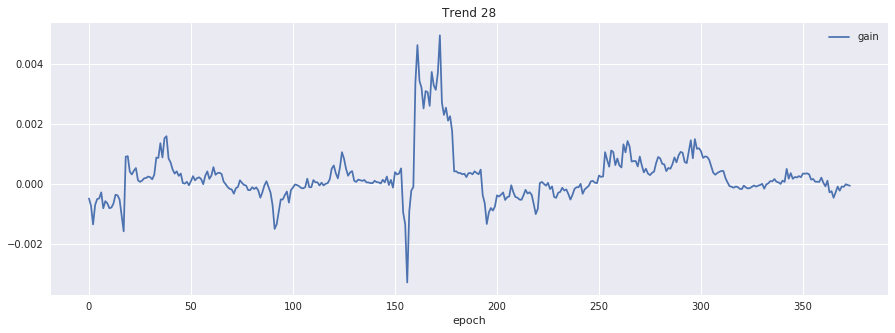

Acc: 0.59
TotGain: 0.08801936410423668


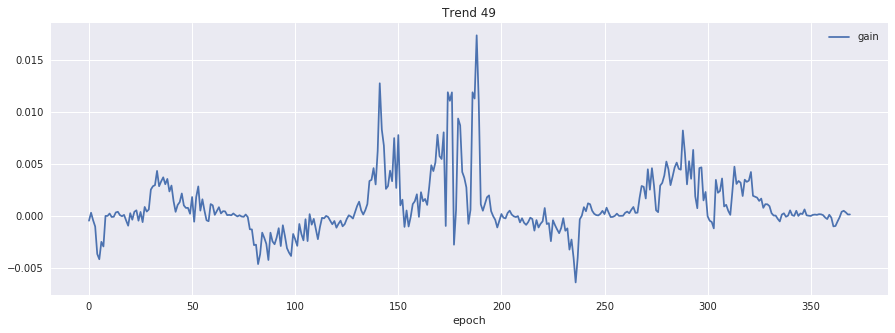

Acc: 0.62
TotGain: 0.36222416518941974


=======================  NFLX ============================



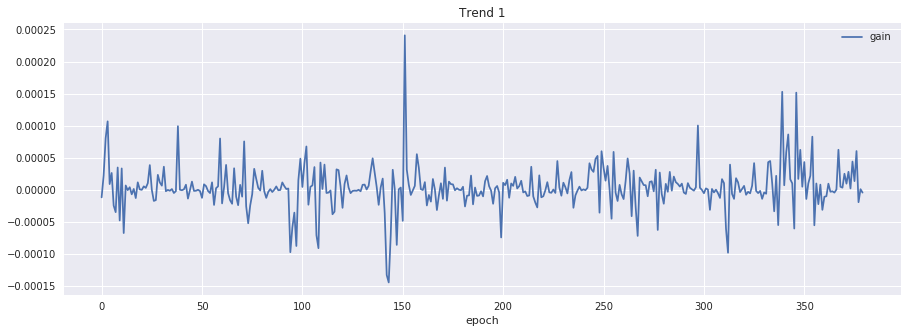

Acc: 0.56
TotGain: 0.0014570658130665635


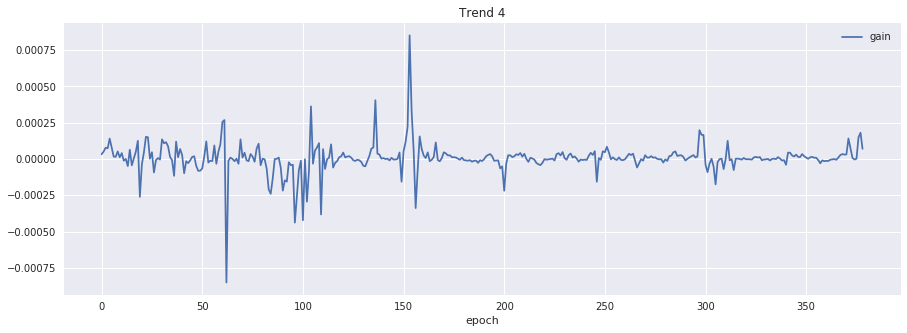

Acc: 0.56
TotGain: 0.0022728911339242835


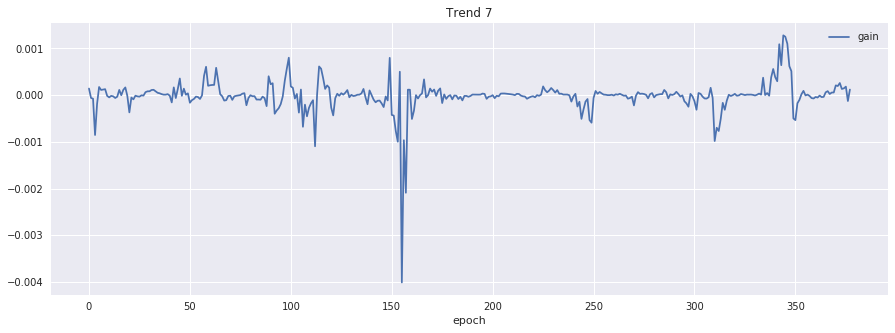

Acc: 0.49
TotGain: -0.006581004798895645


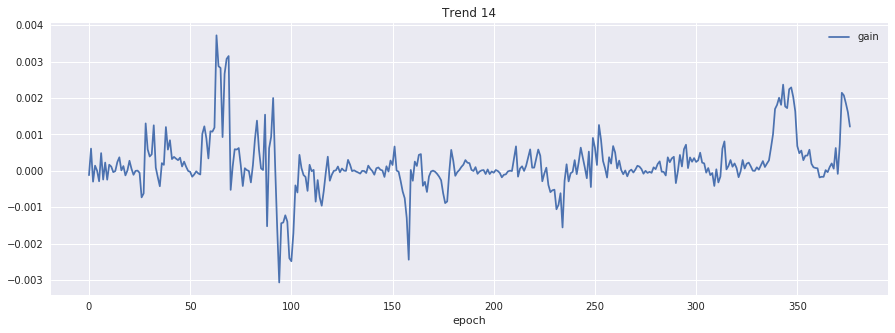

Acc: 0.61
TotGain: 0.06382539304401628


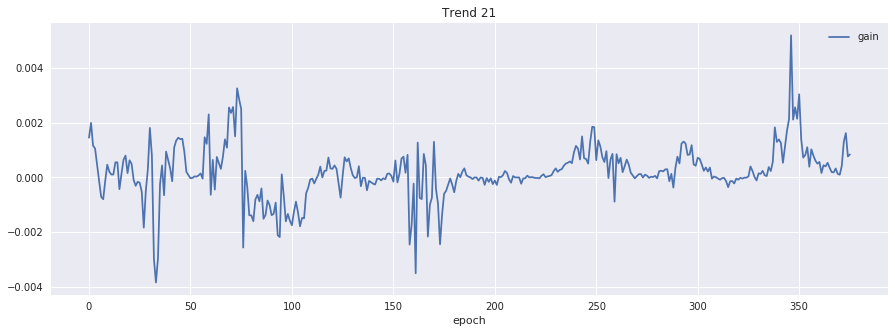

Acc: 0.61
TotGain: 0.0675038946290527


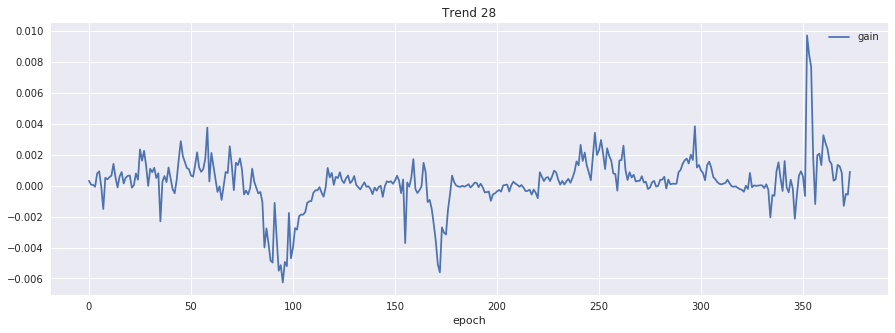

Acc: 0.61
TotGain: 0.07154125902547114


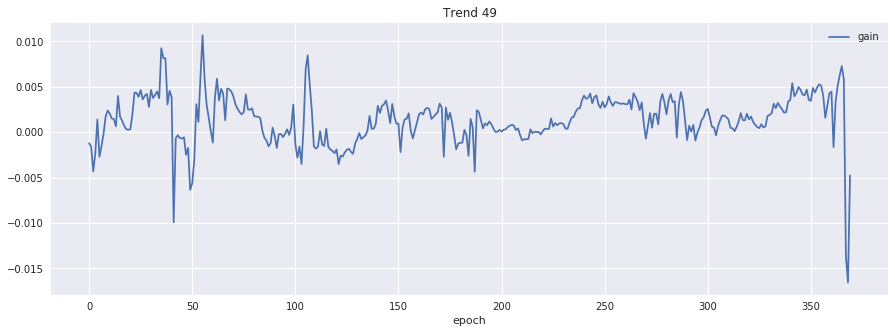

Acc: 0.77
TotGain: 0.5162332460122198
Sum of all gains: 1.4199940332750445


In [11]:
## REGRESSION
portfolio = 10000

sum_gains = 0
for ticker in tickers:
    print('\n\n======================= ',ticker,'============================\n')
    news =  pd.read_csv(newsPath+ticker+'.csv')
    price =  pd.read_csv(pricePath+ticker+'.csv')
    price = price.rename(index=str, columns={"date": "DATE"})
    news = news.rename(index=str, columns={"initTime": "DATE"})
    news['DATE'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in news['DATE']]
    # This datased is already GMT+0
    price['DATE'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in price['DATE']]
    #ALLIGNMENT
    initDate = datetime(2017,5,22,14,0,0)
    finalDate = datetime(2018,6,20,19,0,0)
    price.drop(price[price.DATE > finalDate].index, inplace=True)
    price.drop(price[price.DATE < initDate].index, inplace=True)
    price = price.reset_index(drop=True)
    news.drop(news[news.DATE > finalDate].index, inplace=True)
    news.drop(news[news.DATE < initDate].index, inplace=True)
    news = news.reset_index(drop=True)

    #Controllo allignment
    for data in news['DATE']:
        if data not in price['DATE'].tolist():
            print(data)
    assert len(price) == len(news)

    # FEATURES EXTRACTION
    sentiment = news.drop(['Unnamed: 0', 'DATE'], axis=1)
    X = pd.concat([sentiment, sentiment.rolling(5).mean()],axis=1)
    X = pd.concat([X, sentiment.rolling(10).mean()],axis=1)
    X = pd.concat([X, sentiment.rolling(15).mean()],axis=1)
    X = pd.concat([X, sentiment.rolling(20).mean()],axis=1)

    X = np.nan_to_num(np.asarray(X, dtype=float))
    min_max_scaler = preprocessing.MinMaxScaler()
    X = np.asarray(min_max_scaler.fit_transform(X))
    
    accs = list()
    MCCs = list()
    for TREND_WINDOW in TREND_WINDOWs:
        #CONSTRUCT LABELS
        y = list()
        x = list()
        up = 0
        down = 0
        for i in range(0,len(price)-TREND_WINDOW):
            y.append((price.iloc[i+TREND_WINDOW]['close']-price.iloc[i]['close'])/price.iloc[i]['close'])
            x.append(X[i])
        
        #EXPERIMENT
        y = np.array(y)
        x = np.array(x)
        train=0.8
        nt=math.ceil(len(x)*train)
        x_tv = x[:nt]
        y_tv = y[:nt]
        x_test = x[nt:]
        y_test = y[nt:]
        nn = NN_regression(x_tv.shape[1])
        
        history = nn.fit(x_tv,y_tv, validation_data=(x_test, y_test), epochs=20, batch_size=128,verbose=0)
#         plt.figure(figsize=(15,7))
#         plt.plot(history.history['loss'], 'b--', label='loss_train')
#         plt.plot(history.history['val_loss'], 'r--', label='loss_test')
#         plt.title('Trend '+str(TREND_WINDOW))
#         plt.xlabel('epoch')
#         plt.legend()
#         plt.show()
        y_pred = nn.predict(x_test)
        y_pred = [v[0] for v in y_pred]
        assert len(y_pred) == len(y_test)
        #acc = sum([1 if (y_test[i]*y_pred[i] > 0) else 0 for i in range(len(y_pred))])/len(y_pred)
        plt.figure(figsize=(15,5))
        gain = [y_test[i]*y_pred[i] for i in range(len(y_pred))]
        plt.plot(gain, label='gain')
        plt.title('Trend '+str(TREND_WINDOW))
        plt.xlabel('epoch')
        plt.legend()
        plt.show()
        y_test = [1 if sample > 0 else 0 for sample in y_test]
        y_pred = [1 if sample > 0 else 0 for sample in y_pred]
        acc = [1 if y_test[i] == y_pred[i] else 0 for i in range(len(y_pred))]
        acc = sum(acc)/len(acc)
        print('Acc: '+"{0:.2f}".format(acc))
        print('TotGain: '+str(sum(gain)))
        sum_gains += sum(gain)
        
        
print('Sum of all gains: '+str(sum_gains))